# Online Payment Fraud Detection Project

In this project we try to detect online payment frauds with Machine Learning models. We will compare and evaluate different models to detect if a transaction is fraudolent or not, by training these models on a dataset containing more than 6 millions data points.
This is a Classification Task in a Supervised Learning environment, the model will need to recognize whether the transaction is fraudolent or not by detecting abnormal activities in the input features.

## Splitting training/test set

We need to split our dataset even before doing any other analysis because otherwise there's a high chance of overfitting, this would happen because the feature engineering would happen on the whole dataset. Another reason is that we would lose the ability of getting an unbiased performance evaluation of our model, this means that when the model would see some new data it's performance would decrease from our test set predictions.

In [146]:
# Let's import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [147]:
df = pd.read_csv("onlinefraud.csv")

In [148]:
train_set, test_set = train_test_split(df, test_size=0.1)

## Data exploration

In this section we will explore the dataset by analyzing each feature and the relationships with each other

We import our dataset and visualize the first couple of rows

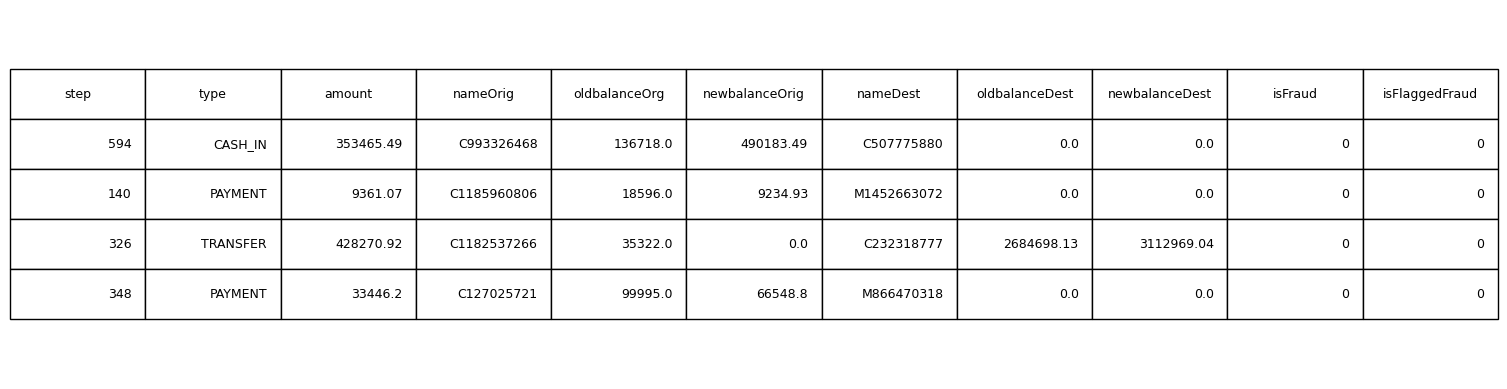

In [149]:
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
# ax.axis('tight')

table = ax.table(cellText=train_set.values[[0, 1, 2, 3]], colLabels=train_set.columns, loc='center')
table.set_fontsize(40)
table.scale(3.0, 3.0)

# fig.tight_layout()
plt.show()

### Exploring features

We can now analyze each feature and detect correlations. The following is the list of columns:
- step: it represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance of customer before the transaction
- newbalanceOrig: balance of customer after the transaction
- nameDest: receiver customer of the transaction
- oldbalanceDest: initial balance of receiver customer before the transaction
- newbalanceDest: the new balance of receiver customer after the transaction
- isFraud: fraud transaction, this is the target label
- isFlaggedFraud: this feature is not described in the dataset description

We can visualize some of the most interesting features

#### Step

It represents a unit of time where 1 step equals 1 hour, in the following graph we can see the time distribution.

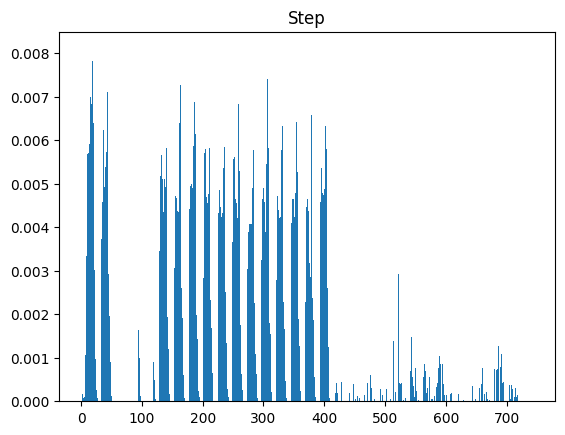

In [150]:
step = train_set["step"]
max_hours = step.max()

plt.title('Step')
plt.hist(step, max_hours, density=True)
plt.show()

#### Type

It represent a type of online transaction, there are 5 classes:
- CASH_OUT
- PAYMENT
- CASH_IN
- TRANSFER
- DEBIT

We can plot its distribution and check which one is the most frequent in our dataset.

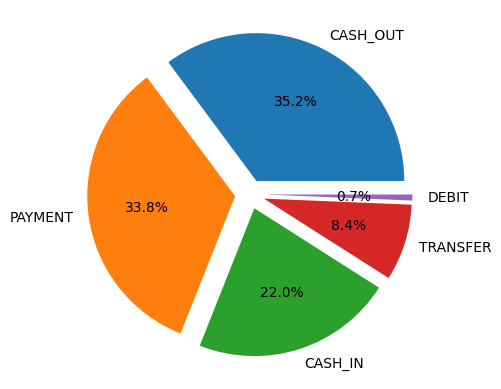

In [151]:
type = train_set["type"].value_counts()
transaction_names = type.index.to_list()
quantity = type.values
expl = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
figure = plt.pie(quantity, labels=transaction_names, explode=expl, autopct='%1.1f%%')
plt.show()

It looks like most of the transactions are either CASH_OUT or PAYMENT, so the majority of frauds will be of one of this two categories.

#### isFraud

We can notice from the graphs below that this feature is imbalanced, which is not ideal for a classification task.

,isFraud
isFraud,
0,5718947
1,7411


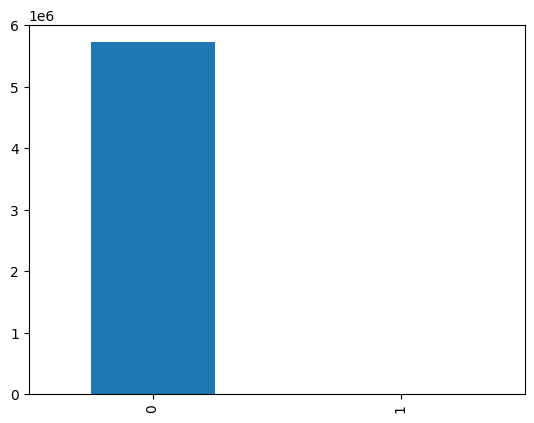

In [152]:
train_set["isFraud"].value_counts().plot(kind='bar')
pd.pivot_table(train_set, index=train_set["isFraud"], values='isFraud', aggfunc='count')

#### Amount

Let's see the 100 largest transaction imports

In [153]:
train_set.nlargest(100, "amount")

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3686583,276,TRANSFER,92445516.64,C1715283297,0.0,0.0,C439737079,9.595980e+03,9.245511e+07,0,0
4060598,300,TRANSFER,73823490.36,C2127282686,0.0,0.0,C753026640,9.362401e+07,1.674475e+08,0,0
4146397,303,TRANSFER,71172480.42,C2044643633,0.0,0.0,C84111522,1.134615e+08,1.846340e+08,0,0
3946920,286,TRANSFER,69886731.30,C1425667947,0.0,0.0,C167875008,1.515387e+08,2.214254e+08,0,0
3911956,284,TRANSFER,69337316.27,C1584456031,0.0,0.0,C1472140329,1.130072e+08,1.823446e+08,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4014659,299,TRANSFER,40782666.97,C445600135,0.0,0.0,C1213359698,4.143794e+07,8.222060e+07,0,0
4064987,300,TRANSFER,40686891.57,C1773319125,0.0,0.0,C1246973714,4.620592e+07,8.689281e+07,0,0
3802364,281,TRANSFER,40639589.17,C385252041,0.0,0.0,C744189981,1.011630e+08,1.418026e+08,0,0
3759492,279,TRANSFER,40576871.68,C231288689,0.0,0.0,C2120613885,4.204843e+07,8.262530e+07,0,0


But neither of this transactions is a fraud

In [154]:
x = train_set.nlargest(100, "amount").isFraud
counter = 0
if 1 in x.values:
    counter +=1
counter

0

We can conclude that frauds are happening in transactions that have low amount of money

#### oldBalanceOrig

We can plot the 10 largest balances of the dataset and compare them with the newBalanceOrig

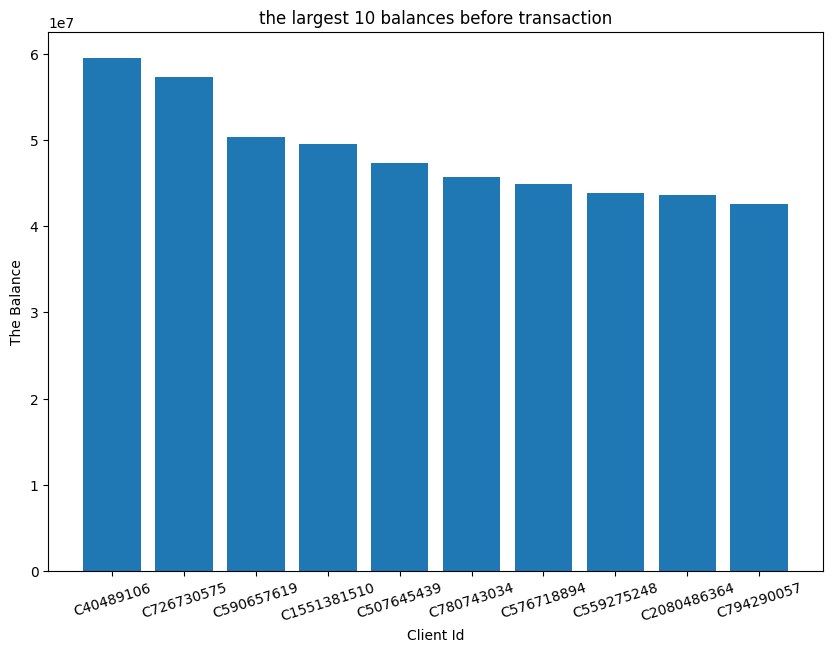

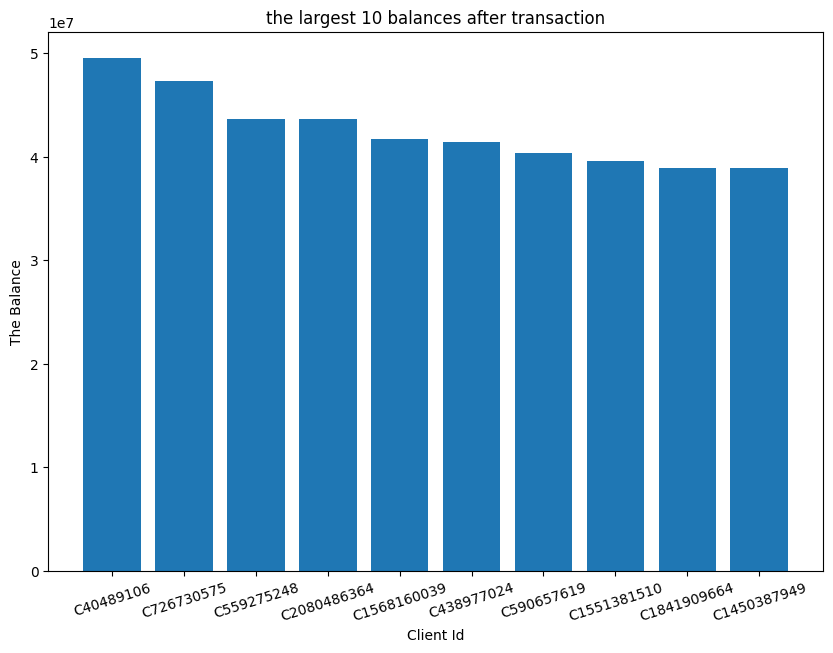

In [155]:
# Before Transaction
plt.figure(figsize = [10,7])
plt.bar(train_set.nlargest(10, 'oldbalanceOrg').nameOrig, train_set.nlargest(10, 'oldbalanceOrg').oldbalanceOrg)
plt.xticks(rotation = 17.5) # to give more spacing for IDs
plt.title('the largest 10 balances before transaction')
plt.xlabel('Client Id')
plt.ylabel('The Balance')
plt.show()

# After Transaction
plt.figure(figsize = [10,7])
plt.bar(train_set.nlargest(10, 'newbalanceOrig').nameOrig, train_set.nlargest(10, 'newbalanceOrig').newbalanceOrig)
plt.xticks(rotation = 17.5) # to give more spacing for IDs
plt.title('the largest 10 balances after transaction')
plt.xlabel('Client Id')
plt.ylabel('The Balance')
plt.show()

The first two clients remain the same.
We can also plot the distribution before and after the transaction.

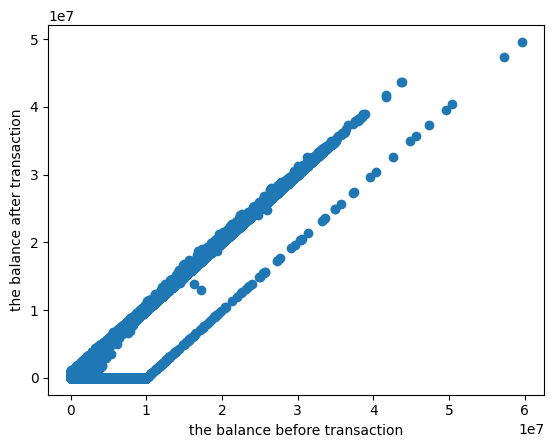

In [156]:
plt.scatter(train_set["oldbalanceOrg"], train_set["newbalanceOrig"])
plt.xlabel('the balance before transaction')
plt.ylabel('the balance after transaction')
plt.show()

### Finding correlations

In [157]:
train_set[['oldbalanceOrg', 'newbalanceOrig']].corr()

,oldbalanceOrg,newbalanceOrig
oldbalanceOrg,1.000000,0.998798
newbalanceOrig,0.998798,1.000000


The sampling distribution shows a strong positive correlation between the balance before and after the transaction.
Now let's have a look at the correlation between features of dataframe compared to the isFraud column.

isFraud           1.000000
amount            0.077086
isFlaggedFraud    0.043436
step              0.031740
oldbalanceOrg     0.010239
newbalanceDest    0.000318
oldbalanceDest   -0.006158
newbalanceOrig   -0.008133
Name: isFraud, dtype: float64


<AxesSubplot: >

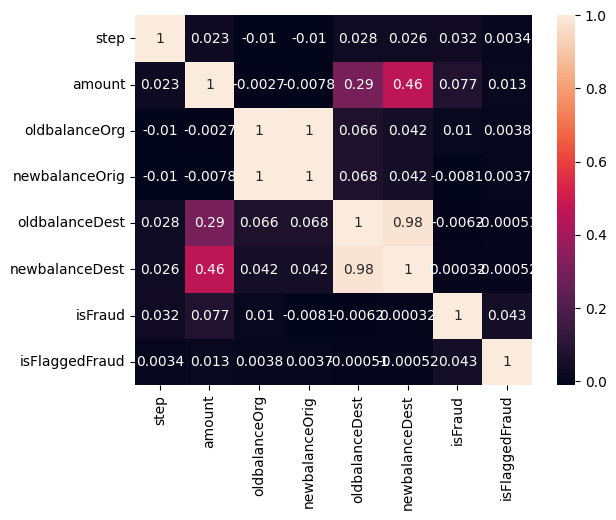

In [158]:
corr_isFraud = train_set.corr(numeric_only=True)
print(corr_isFraud["isFraud"].sort_values(ascending=False))

sb.heatmap(corr_isFraud, annot=True)

As we can see from these results and the observations we made in the previous chapter, it seems that isFraud is not strongly correlated with other columns.

## Preprocessing and Feature Selection

We check if there are any missing features in the dataset

In [159]:
print(train_set.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


As we can see there aren't null values in any feature, so we won't need to do some data cleaning.

We observed at the beginning that for the isFlaggedFraud column there's not much information, it is not clear what is it's purpose. We can see that it is utilized in the dataset only few times, so we drop it from the dataframe.
The correlation map also shows that there's no correlation between frauds and the customers IDs, so we can remove them.
To drop columns we need to create a custom Transformer

In [160]:
train_set["isFlaggedFraud"].value_counts()

0    5726344
1         14
Name: isFlaggedFraud, dtype: int64

In [161]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

Next we create a Pipeline of transformations we need to execute on our data, this way we can have a predefined course also for new data before we can fit the model

In [162]:
# This pipeline handles both numerical and categorical data
# But it also returns a numpy array instead of a dataframe, so we need to do some tricks
cat_attribs = ["type"]
num_attribs = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
drop_attribs = ['isFlaggedFraud', 'nameOrig', 'nameDest']

full_pipeline = ColumnTransformer([
    ("dropCol", "drop", drop_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
    ("num", StandardScaler(), num_attribs)
], verbose_feature_names_out=False, remainder='passthrough')

train_set = pd.DataFrame(full_pipeline.fit_transform(train_set), columns=full_pipeline.get_feature_names_out())
train_set.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1.0,0.0,0.0,0.0,0.0,0.287800,-0.241420,-0.124836,-0.324226,-0.333725
1,0.0,0.0,0.0,1.0,0.0,-0.282553,-0.282321,-0.289329,-0.324226,-0.333725
2,0.0,0.0,0.0,0.0,1.0,0.411790,-0.276530,-0.292488,0.466738,0.514514
3,0.0,0.0,0.0,1.0,0.0,-0.242632,-0.254136,-0.269727,-0.324226,-0.333725
4,0.0,0.0,0.0,1.0,0.0,-0.294981,-0.288760,-0.292488,-0.324226,-0.333725


## Models Comparison

Let's train some models and compare them, for this project we will use:
- Logistic Regression
- Random Forest
- MLP Neural Network

We will also use cross validation

### First struggles

In [163]:
y = train_set.pop('isFraud')
X = train_set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

KeyError: 'isFraud'

In [ ]:
models = {
    "LR": LogisticRegression(max_iter=300),
    # "KNN": KNeighborsClassifier(n_neighbors=3, n_jobs=-1),
    "RF": RandomForestClassifier(max_depth=6),
}

In [ ]:
for name, model in models.items():
    print(f'Training Model {name} \n--------------')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f'Training Accuracy: {accuracy_score(y_train, model.predict(X_train))}')
    print(f'Testing Accuracy: {accuracy_score(y_val, y_pred)}')
    print(f'Testing Confusion Matrix: \n{confusion_matrix(y_val, y_pred)}')
    print("Recall Score : ",recall_score(y_val, y_pred, average='micro'))    
    print("Precision Score : ",precision_score(y_val, y_pred, average='micro'))     
    print(f"Testing F-1:", f1_score(y_val, y_pred, average='micro' ))
    print('-'*30)

Training Model LR 
--------------
Training Accuracy: 0.9992129274660578
Testing Accuracy: 0.9991652637975956
Testing Confusion Matrix: 
[[857765     58]
 [   659    472]]
Recall Score :  0.9991652637975956
Precision Score :  0.9991652637975956
Testing F-1: 0.9991652637975956
------------------------------
Training Model RF 
--------------
Training Accuracy: 0.9993561249487406
Testing Accuracy: 0.9993527010759599
Testing Confusion Matrix: 
[[857823      0]
 [   556    575]]
Recall Score :  0.9993527010759599
Precision Score :  0.9993527010759599
Testing F-1: 0.9993527010759599
------------------------------


In [ ]:
# prepare test set
y_test = test_set.loc[:, "isFraud"]
X_test = test_set.loc[:, test_set.columns != "isFraud"]

# train choosen model
final_model = LogisticRegression(max_iter=300)
final_model.fit(X_train.values, y_train.values)

# make predictions for test data
y_final_pred = final_model.predict(X_test.values)

# evaluate predictions
print(f'Accuracy: {accuracy_score(y_test, y_final_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_final_pred)}')

ValueError: could not convert string to float: 'CASH_OUT'